# Setup

In [ ]:
!pip install mediapipe
!pip install ninja

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.6/35.6 MB 28.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 56.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 22.6 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 5.29.4
    Uninstalling protobuf-5.29.4:
      Successfully uninstalled protobuf-5.29.4
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.
grpcio-status 1.71.0 requires protobuf<6.0dev,>=5.26.1, but you have protobuf 4.25.6 which is incompatib

In [1]:
from IPython.display import display
from PIL import Image
from tqdm import tqdm

import cv2
# import mediapipe as mp
import numpy as np
import os
import pandas as pd
import shutil
import torch

In [2]:
from google.colab import drive
drive.mount('/content/drive')
os.chdir("/content/drive/MyDrive/CS5242-2025/final_report/generative_models/gan/")

Mounted at /content/drive


In [ ]:
# Clone git repo
!git clone https://github.com/NVlabs/stylegan3.git

# Get pretrained weights
os.makedirs("pretrained_weights_gan", exist_ok=True)
!wget https://api.ngc.nvidia.com/v2/models/nvidia/research/stylegan3/versions/1/files/stylegan3-r-ffhqu-256x256.pkl -O pretrained_weights_gan/stylegan3-pretrained.pkl

Cloning into 'stylegan3'...
remote: Enumerating objects: 212, done.
remote: Counting objects: 100% (166/166), done.
remote: Compressing objects: 100% (70/70), done.
remote: Total 212 (delta 101), reused 96 (delta 96), pack-reused 46 (from 1)
Receiving objects: 100% (212/212), 4.16 MiB | 7.38 MiB/s, done.
Resolving deltas: 100% (107/107), done.


# Data Preprocessing

In [ ]:
# CHANGE IF USING COLAB
src_path = "/kaggle/input/ai-vs-human-generated-dataset"
dst_path = "raw_face_data"

real_filenames = pd.read_csv(f"{src_path}/train.csv").loc[lambda x: x.label == 0]["file_name"]

os.makedirs(dst_path, exist_ok=True)
count_gray = count_face = 0

# Mediapipe setup
mp_face_detection = mp.solutions.face_detection
face_detection = mp_face_detection.FaceDetection(model_selection=0, min_detection_confidence=0.5)

# Process each image
for filename in tqdm(real_filenames):
    src = f"{src_path}/{filename}"
    image = Image.open(src)

    # Convert grayscale to 3-channel RGB
    if image.mode == "L":
        image = image.convert('RGB')
        count_gray += 1
    rgb_image = cv2.cvtColor(np.array(image), cv2.COLOR_BGR2RGB)

    # Detect faces
    results = face_detection.process(rgb_image)
    if results.detections:
        # Copy image to finetune data folder if it is a face
        bgr_image = cv2.cvtColor(rgb_image, cv2.COLOR_RGB2BGR)
        cv2.imwrite(f"{dst_path}/{filename[11:]}", bgr_image)
        count_face += 1
print(f"Converted {count_gray} grayscale images to RGB")
print(f"Found {count_face} image with faces")

face_detection.close()

100%|██████████| 39975/39975 [09:17<00:00, 71.65it/s]

Converted 176 grayscale images to RGB
Found 8752 image with faces


In [ ]:
!python stylegan3/dataset_tool.py --dest=preprocessed_face_data --source=raw_face_data --resolution=256x256 --transform=center-crop

100%|███████████████████████████████████████| 8752/8752 [02:30<00:00, 58.33it/s]


# Finetuning

In [ ]:
# !python stylegan3/train.py --outdir=finetune_runs_gan --cfg=stylegan3-r --data=preprocessed_face_data \
#     --gpus=2 --batch=32 --batch-gpu=8 --gamma=2 --kimg=5 --tick=2 --snap=2 \
#     --freezed=10 --cbase=16384 \
#     --resume=pretrained_weights_gan/stylegan3-pretrained.pkl


Training options:
{
  "G_kwargs": {
    "class_name": "training.networks_stylegan3.Generator",
    "z_dim": 512,
    "w_dim": 512,
    "mapping_kwargs": {
      "num_layers": 2
    },
    "channel_base": 32768,
    "channel_max": 1024,
    "magnitude_ema_beta": 0.9988915792636801,
    "conv_kernel": 1,
    "use_radial_filters": true
  },
  "D_kwargs": {
    "class_name": "training.networks_stylegan2.Discriminator",
    "block_kwargs": {
      "freeze_layers": 10
    },
    "mapping_kwargs": {},
    "epilogue_kwargs": {
      "mbstd_group_size": 4
    },
    "channel_base": 16384,
    "channel_max": 512
  },
  "G_opt_kwargs": {
    "class_name": "torch.optim.Adam",
    "betas": [
      0,
      0.99
    ],
    "eps": 1e-08,
    "lr": 0.0025
  },
  "D_opt_kwargs": {
    "class_name": "torch.optim.Adam",
    "betas": [
      0,
      0.99
    ],
    "eps": 1e-08,
    "lr": 0.002
  },
  "loss_kwargs": {
    "class_name": "training.loss.StyleGAN2Loss",
    "r1_gamma": 2.0,
    "blur_init_s

# Generation

In [ ]:
generate = True
if generate:
    !python stylegan3/gen_images.py --outdir=generated_gan_pretrained --trunc=1 --seeds=500-5499 \
        --network=pretrained_weights_gan/stylegan3-pretrained.pkl
    !python stylegan3/gen_images.py --outdir=generated_gan_finetuned --trunc=1 --seeds=500-5499 \
        --network=finetune_runs_gan/00000-stylegan3-r-preprocessed_face_data-gpus2-batch32-gamma2/network-snapshot-000005.pkl

Streaming output truncated to the last 5000 lines.
Done.
Generating image for seed 501 (1/5000) ...
Generating image for seed 502 (2/5000) ...
Generating image for seed 503 (3/5000) ...
Generating image for seed 504 (4/5000) ...
Generating image for seed 505 (5/5000) ...
Generating image for seed 506 (6/5000) ...
Generating image for seed 507 (7/5000) ...
Generating image for seed 508 (8/5000) ...
Generating image for seed 509 (9/5000) ...
Generating image for seed 510 (10/5000) ...
Generating image for seed 511 (11/5000) ...
Generating image for seed 512 (12/5000) ...
Generating image for seed 513 (13/5000) ...
Generating image for seed 514 (14/5000) ...
Generating image for seed 515 (15/5000) ...
Generating image for seed 516 (16/5000) ...
Generating image for seed 517 (17/5000) ...
Generating image for seed 518 (18/5000) ...
Generating image for seed 519 (19/5000) ...
Generating image for seed 520 (20/5000) ...
Generating image for seed 521 (21/5000) ...
Generating image for seed 52

In [ ]:
import numpy as np

In [8]:
dir = "gan/generated_gan_pretrained"
folder_path = "generated_gan_pretrained"
filenames = [f"{dir}/{f}" for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]
df = pd.DataFrame({'id': filenames})
df['label'] = 1
df.to_csv(f"iname_gan_pretrained.csv", index=False)
df.shape

(5000, 2)

In [7]:
dir = "gan/generated_gan_finetuned"
folder_path = "generated_gan_finetuned"
filenames = [f"{dir}/{f}" for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]
df = pd.DataFrame({'id': filenames})
df['label'] = 1
df.to_csv(f"iname_gan_finetuned.csv", index=False)
df.shape

(5000, 2)

In [9]:
filenames.sort()
filenames[-1]

'gan/generated_gan_pretrained/seed4999.png'

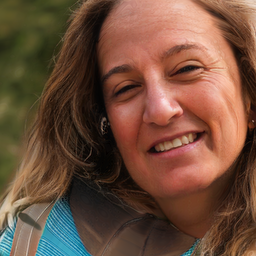

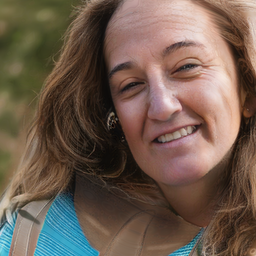

In [ ]:
seed = "02"
output_pretrained = "./generated_gan_pretrained"
img = Image.open(f"{output_pretrained}/seed00{seed}.png")
display(img)

output_finetuned = "./generated_gan_finetuned"
img = Image.open(f"{output_finetuned}/seed00{seed}.png")
display(img)